In [1]:
import torch
from torch import nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
checkpoint_path = 'model/checkpoints/'

# Know your Data

In [3]:
# Design custom dataset.
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __getitem__(self, index):
        img1 = self.image_list[index][0]
        img2 = self.image_list[index][1]
        label = self.image_list[index][2]
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            label = self.transform(label)

        return img1, img2, label

    def __len__(self):
        return len(self.image_list)

# Transformations and Augmentations

---

Each image undergoes 5 types of <b>Data Augmentation</b>:
+ Horizontal Flip
+ Vertical Flip
+ Rotation by 90 degrees
+ Rotation by 180 degrees
+ Rotation by 270 degrees

---

<b>Transformations</b> include converting PIL image to a Tensor object 

In [4]:
# Define the crop size
crop_size = (448, 784)

# Define a custom lambda function to crop the image.
crop_fn = lambda x: x[:, :crop_size[0], :crop_size[1]]

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_fn),
    
])

augmentations = [
    lambda x: TF.hflip(x),  # Horizontal flip
    lambda x: TF.vflip(x),  # Vertical flip
    lambda x: TF.rotate(x, 90),  # 90-degree rotation
    lambda x: TF.rotate(x, 180),  # 180-degree rotation
    lambda x: TF.rotate(x, 270),  # 270-degree rotation
]

In [5]:
data_list = []
for i in range(7):
    data_path = f'SZTAKI_AirChange_Benchmark/Szada/{i + 1}/'
    data_list.append((data_path + "im1.bmp", data_path + "im2.bmp", data_path + "gt.bmp"))

for i in range(5):
    data_path = f'SZTAKI_AirChange_Benchmark/Tiszadob/{i + 1}/'
    data_list.append((data_path + "im1.bmp", data_path + "im2.bmp", data_path + "gt.bmp"))

print(f'The number of images in the dataset before augmentation of each image = {len(data_list)}')

# Image list after applying the augmentations on the each image.
train_image_list = []
augmented_train_image_list = []
test_image_list = []

for (img1_path, img2_path, label_path) in data_list:
    img1 = Image.open(img1_path).convert('RGB')
    img2 = Image.open(img2_path).convert('RGB')
    label = Image.open(label_path).convert('L') 
    
    # Add the the whole image without augmentations to the test list of images.
    test_image_list.append((img1, img2, label))
    
    # Convert PIL images to PyTorch Tensors for easier slicing
    transform = transforms.ToTensor()
    tensor_img1 = transform(img1)
    tensor_img2 = transform(img2)
    tensor_label = transform(label)
    
    train_image_size = 112
    x_index = img1.size[0] - crop_size[0]
    y_index = img1.size[1] - crop_size[1]
    
    # Divide the remaining image after cropping top left part into two rectangles.
    # Index through rectangle number one and extract images.
    # Image size after extracting will be 112 x 112
    for i in range(0, img1.size[1], 22):
        if(i + train_image_size >= img1.size[1]):
            break

        train_image_list.append(((tensor_img1[:, 
                                              i : i + train_image_size, 
                                              y_index : y_index + train_image_size]), 
                                (tensor_img2[:, 
                                             i : i + train_image_size, 
                                             y_index : y_index + train_image_size]), 
                                (tensor_label[:, 
                                              i : i + train_image_size, 
                                              y_index : y_index + train_image_size])))
    
    # Index through rectangle number two and extract images.
    for i in range(0, img1.size[0], 22):
        if(i + train_image_size >= img1.size[0]):
            break

        train_image_list.append(((tensor_img1[:, 
                                              x_index : x_index + train_image_size, 
                                              i : i + train_image_size]), 
                                 (tensor_img2[:, 
                                              x_index : x_index + train_image_size, 
                                              i : i + train_image_size]), 
                                 (tensor_label[:, 
                                               x_index : x_index + train_image_size, 
                                               i : i + train_image_size])))

# Apply augmentations to each image that was extracted for training
for (img1, img2, label) in train_image_list:
    for augment in augmentations:
        augmented_train_image_list.append((augment(img1), augment(img2), augment(label)))

The number of images in the dataset before augmentation of each image = 12


In [6]:
batch_size = 32

# Train dataset and dataloader.
train_siamese_dataset = SiameseDataset(augmented_train_image_list)
train_siamese_dataloader = torch.utils.data.DataLoader(train_siamese_dataset, batch_size=batch_size, shuffle=False)

# Print the information about the train dataset and dataloader.
print(f'The number of images in the train dataset after augmentation of each image = {len(train_siamese_dataset)}')
print(f'The number of batches in the test dataset = {len(train_siamese_dataloader)}')

# Test dataset and dataloader.
test_siamese_dataset = SiameseDataset(test_image_list, transform=test_transform)
test_siamese_dataloader = torch.utils.data.DataLoader(test_siamese_dataset, batch_size=2, shuffle=False)

# Print the information about the test dataset and dataloader.
print(f'\nThe number of images in the test dataset = {len(test_siamese_dataset)}')
print(f'The number of batches in the test dataset = {len(test_siamese_dataloader)}')

The number of images in the train dataset after augmentation of each image = 3780
The number of batches in the test dataset = 119

The number of images in the test dataset = 12
The number of batches in the test dataset = 6


In [7]:
print(next(iter(test_siamese_dataloader))[0][1].shape)

torch.Size([3, 448, 784])


The shape of images is torch.Size([3, 112, 112])
The number of images in one batch = 32


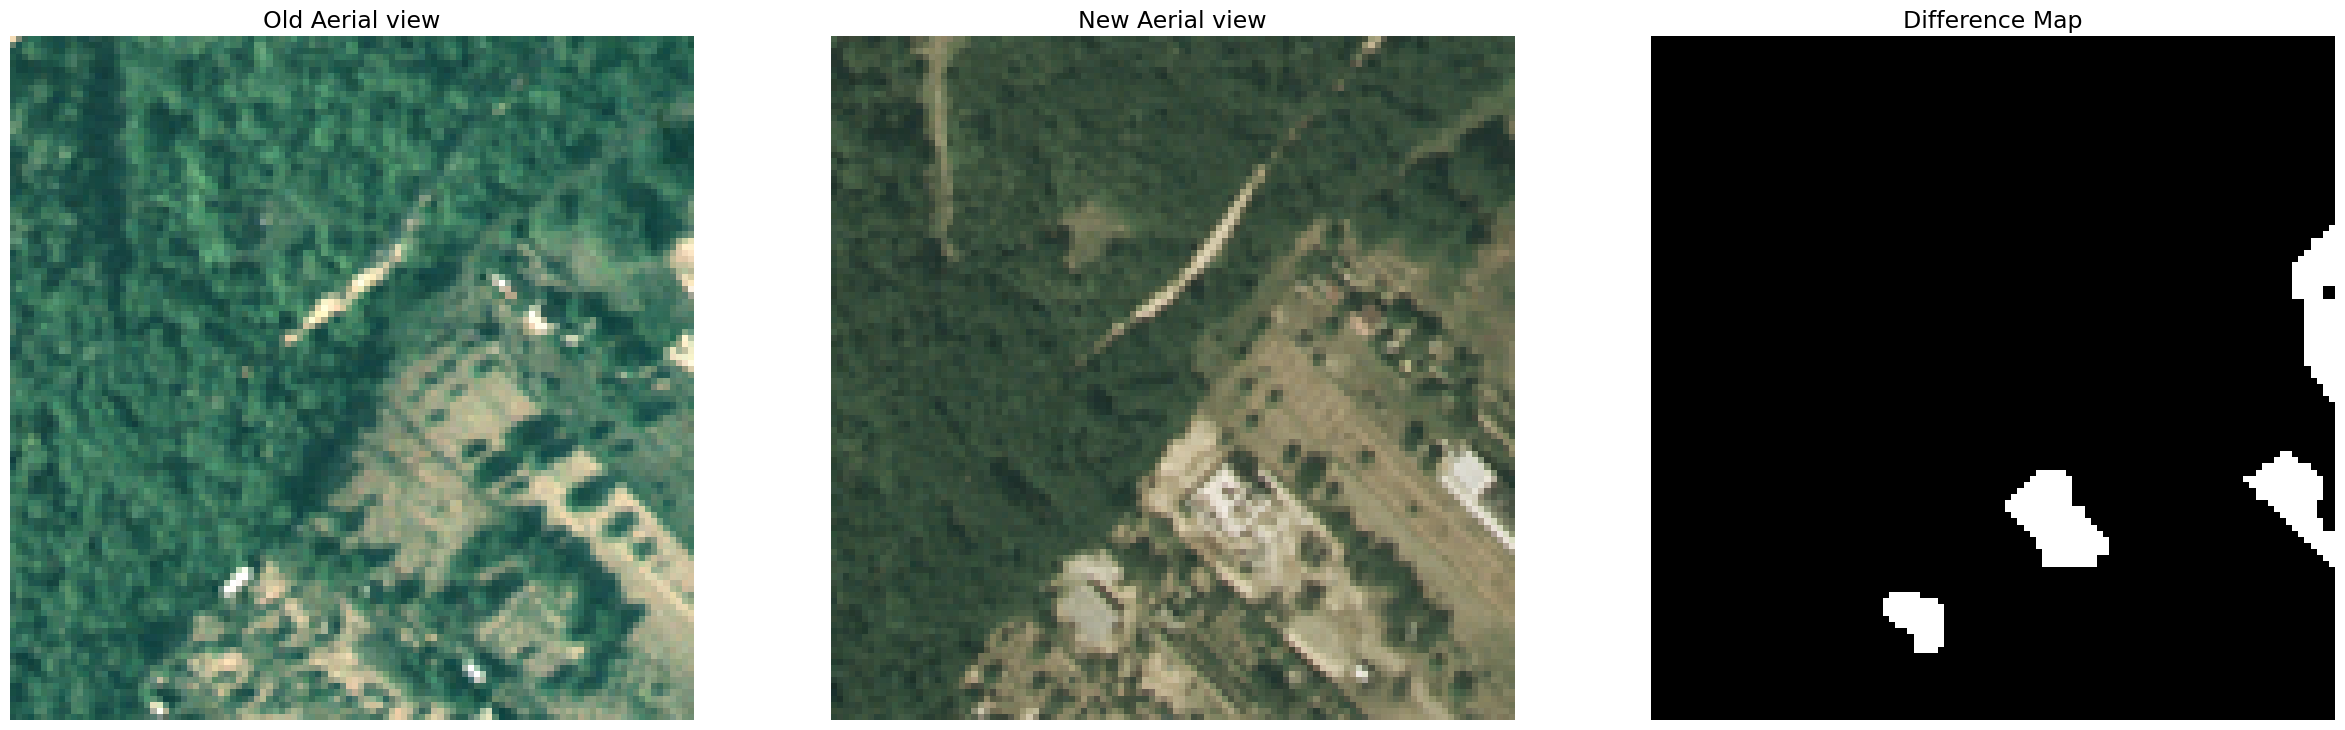

In [8]:
# Loop runs for iterations = number of batches. 
# We have only one batch for this dataset with batch_size = min(total number of images, 64).
for img1, img2, labels in train_siamese_dataloader:
    
    print(f'The shape of images is {img1.shape[1:]}')
    print(f'The number of images in one batch = {img1.shape[0]}')
    
    # You can vary the number_of_images value to print the number of images (set of 3) you need.
    number_of_images = 1 # maximum size of img1.shape[0].
    
    for i, j in zip([x for x in range(number_of_images)], [(max(3, number_of_images) * x + 1) for x in range(number_of_images)]):
        
        # Process old image.
        # Transpose is applied to all images to get the image in the form HWC from CHW.
        image1 = img1[i].transpose(0, 2).transpose(0, 1)

        plt.figure(figsize = (30, 30))
        plt.subplot(number_of_images, max(3, number_of_images), j)
        plt.imshow(image1)
        plt.axis('off')
        plt.title('Old Aerial view', fontsize = '17')

        # Process new image.
        image2 = img2[i].transpose(0, 2).transpose(0, 1)   

        plt.subplot(number_of_images, max(3, number_of_images), j + 1)
        plt.imshow(image2)
        plt.axis('off')
        plt.title('New Aerial view', fontsize = '17')

        # Process difference map label.
        label = labels[i].transpose(0, 2).transpose(0, 1)

        plt.subplot(number_of_images, max(3, number_of_images), j + 2)
        plt.imshow(label, cmap = 'gray')
        plt.axis('off')
        plt.title('Difference Map', fontsize = '17')
    
    break        

In [9]:
class SiameseCNN(nn.Module):
    """
    Contains the Convolutional Network described in the paper.
    1x1 kernel size is used to get an image representation (in latent space).
    """
    def __init__(self):
        super(SiameseCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding=3),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=9, padding=4),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        )
    
    def forward(self, image1, image2):
        output1 = self.cnn(image1)
        output2 = self.cnn(image2)
        return output1, output2

# Contrastive Loss function

References:
[Contrastive Loss Function in PyTorch](https://jamesmccaffrey.wordpress.com/2022/03/04/contrastive-loss-function-in-pytorch/)

In [10]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, feature_map1, feature_map2, y_hat):
        """
        y_hat = 0 means feature_map1 and feature_map2 are supposed to be same
        y_hat = 1 means feature_map1 and feature_map2 are supposed to be different
        """
        
        # Euclidean distance is taken over the channel dimension 
        euclidean_distance = torch.linalg.norm(feature_map1 - feature_map2, ord=2, dim=1)
        map_shape = list(euclidean_distance.shape)
        
        # Lu and Lc are computed according to the section "Contrastive Loss Function" defined in the paper
        Lu = 1/2 * torch.pow(euclidean_distance, 2) 
        
        # Compute Lc
        delta = torch.pow(self.margin - euclidean_distance, 2)  
        delta = torch.clamp(delta, min=0.0, max=None)
        Lc = 1/2 * delta  
        
        # Debug Lc and Lu shapes
        # print(f'Lc = {Lc.shape}')
        # print(f'Lu = {Lu.shape}')
        
        # Compute the loss
        loss = torch.mean((1 - y_hat) * Lu + (y_hat * Lc))  
        return loss

In [11]:
# Debug the Custom Loss function

loss_func = ContrastiveLoss(2)  # instantiate a loss object

y1 = torch.randn((batch_size, 3, 112, 112), dtype=torch.float32)
y2 = torch.randn((batch_size, 3, 112, 112),dtype=torch.float32)
y_hat = torch.randn((batch_size, 1, 112, 112))

loss = loss_func(y1, y2, y_hat)
print(loss)  

tensor(2.9970)


In [12]:
# Function to save checkpoints during training.
def save_checkpoint(state, filename):
    torch.save(state, filename)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Hyperparameters.
num_epochs = 10
learning_rate = 0.001
margin = 1 # Threshold value above which contribution to loss = 0

criterion = ContrastiveLoss(margin)
siamese_cnn = SiameseCNN()
siamese_cnn = siamese_cnn.to(device)  # Move the model to the GPU
optimizer = torch.optim.Adam(siamese_cnn.parameters(), lr=learning_rate)

In [13]:
torch.cuda.empty_cache()
for epoch in range(num_epochs):
    for i, (img1_batch, img2_batch, labels) in enumerate(train_siamese_dataloader):
        
        img1_batch = img1_batch.to(device)
        img2_batch = img2_batch.to(device)
        labels = labels.to(device)
        
        # Zero your gradients for every batch(do not accumulate)
        optimizer.zero_grad()
        
        # Run forward propagation
        output1, output2 = siamese_cnn(img1_batch, img2_batch)
        
        # Compute loss function and run back propagation
        # Also, update the weights
        loss = criterion(output1, output2, labels)
        loss.backward()
        optimizer.step()
        
        if((i + 1) % 10 == 0):
            print(f'Epoch [{epoch + 1}/{num_epochs}], Iter [{i + 1}/{len(train_siamese_dataloader)}] Loss [{loss.item():.4f}]')
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': siamese_cnn.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(checkpoint_path, f'epoch-{epoch+1}.pth'))
    

# Run inference on the train set

In [14]:
inference_epoch = 10

siamese_cnn = SiameseCNN()
siamese_cnn = siamese_cnn.to(device)  # Move the model to the GPU

model_checkpoint = torch.load(os.path.join(
            checkpoint_path, f'epoch-{inference_epoch}.pth'))

# Load the weights into the model.
siamese_cnn.load_state_dict(model_checkpoint['state_dict'])

<All keys matched successfully>

In [15]:
n = 200 # image number from the dataset
img1 = train_siamese_dataset[n][0].unsqueeze(0).to(device)
img2 = train_siamese_dataset[n][1].unsqueeze(0).to(device)
label = train_siamese_dataset[n][2]

siamese_cnn.eval()
output1, output2 = siamese_cnn(img1, img2)
euclidean_distance = torch.linalg.norm(output1 - output2, ord=2, dim=1)

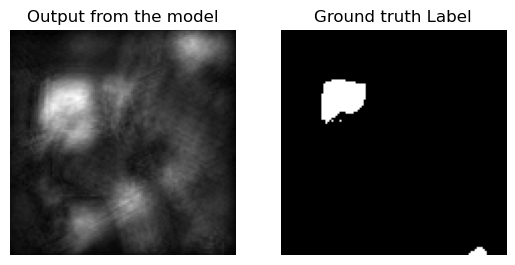

In [16]:
plt.subplot(1, 2, 1)
euclidean_distance = euclidean_distance.permute(1, 2, 0)
euclidean_distance = euclidean_distance.cpu()
euclidean_distance = euclidean_distance.detach().numpy()
plt.imshow(euclidean_distance, cmap = 'gray')
plt.title('Output from the model')
plt.axis('off')


plt.subplot(1, 2, 2)
label = label.squeeze()
plt.title('Ground truth Label')
plt.imshow(label, cmap = 'gray')
plt.axis('off')

plt.show()

# Run Inference on the test set

In [17]:
n = 9 # image number from the dataset
img1 = test_siamese_dataset[n][0].unsqueeze(0).to(device)
img2 = test_siamese_dataset[n][1].unsqueeze(0).to(device)
label = test_siamese_dataset[n][2]

siamese_cnn.eval()
output1, output2 = siamese_cnn(img1, img2)
euclidean_distance = torch.linalg.norm(output1 - output2, ord=2, dim=1)

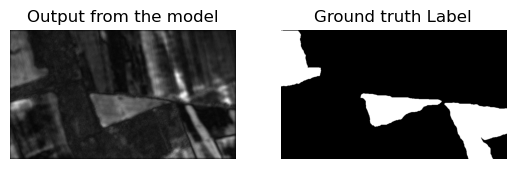

In [18]:
plt.subplot(1, 2, 1)
euclidean_distance = euclidean_distance.permute(1, 2, 0)
euclidean_distance = euclidean_distance.cpu()
euclidean_distance = euclidean_distance.detach().numpy()
plt.imshow(euclidean_distance, cmap = 'gray')
plt.title('Output from the model')
plt.axis('off')


plt.subplot(1, 2, 2)
label = label.squeeze()
plt.title('Ground truth Label')
plt.imshow(label, cmap = 'gray')
plt.axis('off')

plt.show()